In [1]:
import gdown
from gensim.models import KeyedVectors
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# URL del archivo Word2Vec preentrenado
url = "https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK"
# Nombre del archivo descargado
nombre_archivo = "archivo.bin"

# Descargar el archivo desde Google Drive
gdown.download(url, nombre_archivo, quiet=False)

# Cargar el archivo con KeyedVectors con un límite
word2vec_model_google = KeyedVectors.load_word2vec_format(
    nombre_archivo, binary=True, limit=500000
)



Downloading...
From (original): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK
From (redirected): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK&confirm=t&uuid=a14fe00c-6793-4e6d-9697-46cb84bfca3f
To: c:\Users\luist\OneDrive\Escritorio\PruebaRN\archivo.bin
100%|██████████| 3.64G/3.64G [02:38<00:00, 23.0MB/s]


In [2]:
# Cargar los datos de entrenamiento
df = pd.read_csv("news1.csv")

# Filtrar solo las filas con etiquetas 'REAL' o 'FAKE'
df = df[df["label"].isin(["REAL", "FAKE"])]

# Mapear labels a enteros
label_mapping = {"REAL": 1, "FAKE": 0}
df["label"] = df["label"].map(label_mapping)

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.33, random_state=42
)

# Convertir y_train y y_test a arrays de NumPy de tipo entero
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

# Convertir todos los textos a cadenas de texto y llenar valores faltantes
X_train = X_train.apply(lambda x: str(x)).fillna("")
X_test = X_test.apply(lambda x: str(x)).fillna("")

In [3]:
# Exploración de frecuencias de palabras
tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X_train)

# Obtener frecuencias de palabras
word_freq = tokenizer.word_counts
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_words[:20]
print("Top 20 palabras más frecuentes:", top_words)

# Convertir textos a secuencias y aplicar padding
max_length = 80
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

Top 20 palabras más frecuentes: [('the', 191279), ('to', 92226), ('of', 86193), ('and', 78881), ('a', 71545), ('in', 65135), ('that', 45838), ('is', 35058), ('for', 30556), ('on', 26872), ('as', 21707), ('with', 20478), ('it', 19970), ('he', 19151), ('was', 17634), ('are', 16561), ('by', 16369), ('be', 16320), ('this', 16078), ('have', 15775)]


In [4]:
# Crear la matriz de embedding usando el modelo Word2Vec preentrenado
embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i >= 80000:
        continue
    try:
        embedding_vector = word2vec_model_google[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = Sequential()
model.add(
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,
    )
)
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation="sigmoid"))

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Entrenar el modelo
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
history = model.fit(
    X_train_seq,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/20
60/60 [==============================] - 30s 380ms/step - loss: 0.5562 - accuracy: 0.7114 - val_loss: 0.4753 - val_accuracy: 0.7718
Epoch 2/20
60/60 [==============================] - 23s 377ms/step - loss: 0.4346 - accuracy: 0.8043 - val_loss: 0.4033 - val_accuracy: 0.8141
Epoch 3/20
60/60 [==============================] - 22s 375ms/step - loss: 0.3609 - accuracy: 0.8459 - val_loss: 0.4061 - val_accuracy: 0.8235
Epoch 4/20
60/60 [==============================] - 23s 380ms/step - loss: 0.3261 - accuracy: 0.8626 - val_loss: 0.3655 - val_accuracy: 0.8541
Epoch 5/20
60/60 [==============================] - 23s 387ms/step - loss: 0.3511 - accuracy: 0.8430 - val_loss: 0.3506 - val_accuracy: 0.8494
Epoch 6/20
60/60 [==============================] - 22s 374ms/step - loss: 0.2342 - accuracy: 0.9042 - val_loss: 0.4391 - val_accuracy: 0.8541
Epoch 7/20
60/60 [==============================] - 22s 366ms/step - loss: 0.2206 - accuracy: 0.9134 - val_loss: 0.3693 - val_accuracy: 0.8494

In [6]:
# Cargar el archivo de predicciones
df_pred = pd.read_csv("news_pred.csv")

# Tokenizar y aplicar padding a las noticias de predicción
X_pred = df_pred["text"].apply(lambda x: str(x)).fillna("")
X_pred_seq = pad_sequences(tokenizer.texts_to_sequences(X_pred), maxlen=max_length)

# Realizar predicciones
y_pred = model.predict(X_pred_seq)
y_pred_labels = (y_pred > 0.5).astype(int)

# Mapear los labels de vuelta a texto
label_mapping_inv = {1: "REAL", 0: "FAKE"}
df_pred["predicted_label"] = y_pred_labels
df_pred["predicted_label"] = df_pred["predicted_label"].map(label_mapping_inv)

# Mostrar los resultados
print(df_pred[["text", "predicted_label"]])

1/1 [==============================] - 2s 2s/step
                                                text predicted_label
0  Gunmen stormed the offices of the satirical ne...            FAKE
1  World leaders' personal chefs sample Indian ma...            FAKE
2  Tweet Widget by Black Power Front \nWith stude...            FAKE
3  Gay man finds it in himself to tolerate religi...            FAKE
4  Get short URL 0 27 0 0 On Tuesday, National In...            REAL
5  More Floods, More Drought Inevitable. How Bad ...            REAL
6  President Obama’s executive action sparing mil...            REAL


In [7]:
# Verificar si hay alguna predicción incorrecta
# En este caso, no tenemos las etiquetas verdaderas para comparar, así que revisaremos los resultados manualmente
incorrect_prediction = df_pred[df_pred["predicted_label"] != df_pred["label"]]

if not incorrect_prediction.empty:
    print("Predicciones incorrectas encontradas:")
    print(incorrect_prediction[["text", "label", "predicted_label"]])
else:
    print("No se encontraron predicciones incorrectas.")

Predicciones incorrectas encontradas:
                                                text label predicted_label
0  Gunmen stormed the offices of the satirical ne...  REAL            FAKE
4  Get short URL 0 27 0 0 On Tuesday, National In...  FAKE            REAL


In [8]:
# Cargar la base de datos de artículos publicados por Mashable
df_mashable = pd.read_csv("OnlineNewsPopularity.csv")

# Quitar los espacios en blanco de los nombres de las columnas
df_mashable.columns = df_mashable.columns.str.strip()

# Eliminar columnas que no aporten información relevante
df_mashable.drop(columns=["url"], inplace=True)

# Revisar valores ausentes
missing_values = df_mashable.isnull().sum()
print("Valores ausentes por columna:")
print(missing_values[missing_values > 0])

# Si existen valores ausentes, decidir qué hacer (en este caso, eliminaremos filas con valores ausentes)
df_mashable.dropna(inplace=True)

# Calcular indicadores estadísticos principales para las variables numéricas
stats = df_mashable.describe()
print("Indicadores estadísticos principales:")
print(stats)

Valores ausentes por columna:
Series([], dtype: int64)
Indicadores estadísticos principales:
          timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
count  39644.000000    39644.000000      39644.000000     39644.000000   
mean     354.530471       10.398749        546.514731         0.548216   
std      214.163767        2.114037        471.107508         3.520708   
min        8.000000        2.000000          0.000000         0.000000   
25%      164.000000        9.000000        246.000000         0.470870   
50%      339.000000       10.000000        409.000000         0.539226   
75%      542.000000       12.000000        716.000000         0.608696   
max      731.000000       23.000000       8474.000000       701.000000   

       n_non_stop_words  n_non_stop_unique_tokens     num_hrefs  \
count      39644.000000              39644.000000  39644.000000   
mean           0.996469                  0.689175     10.883690   
std            5.231231                

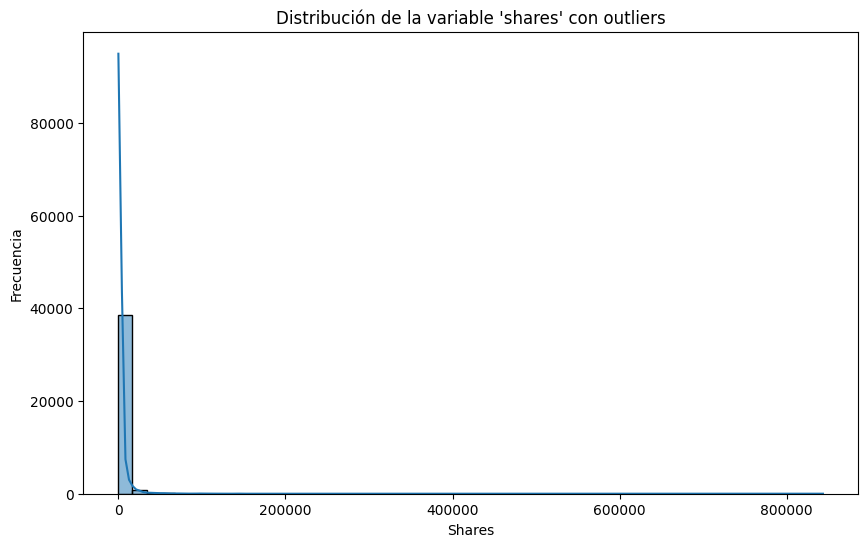

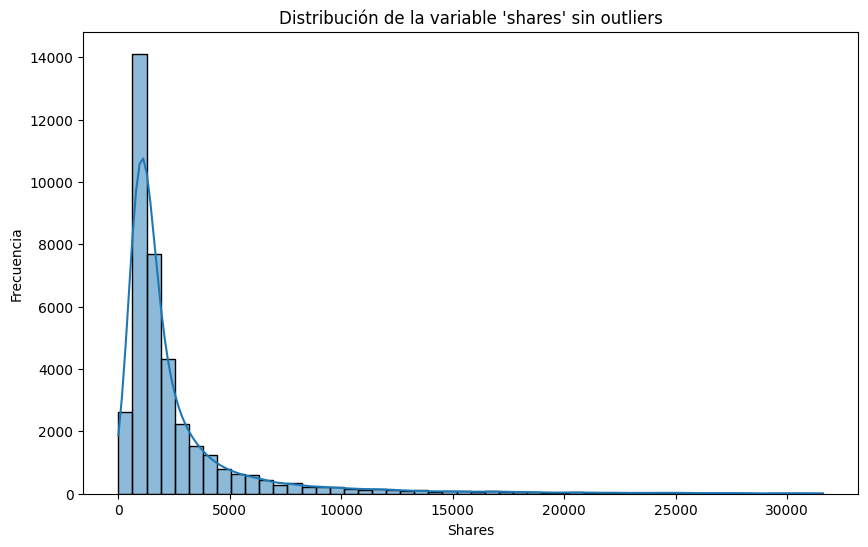

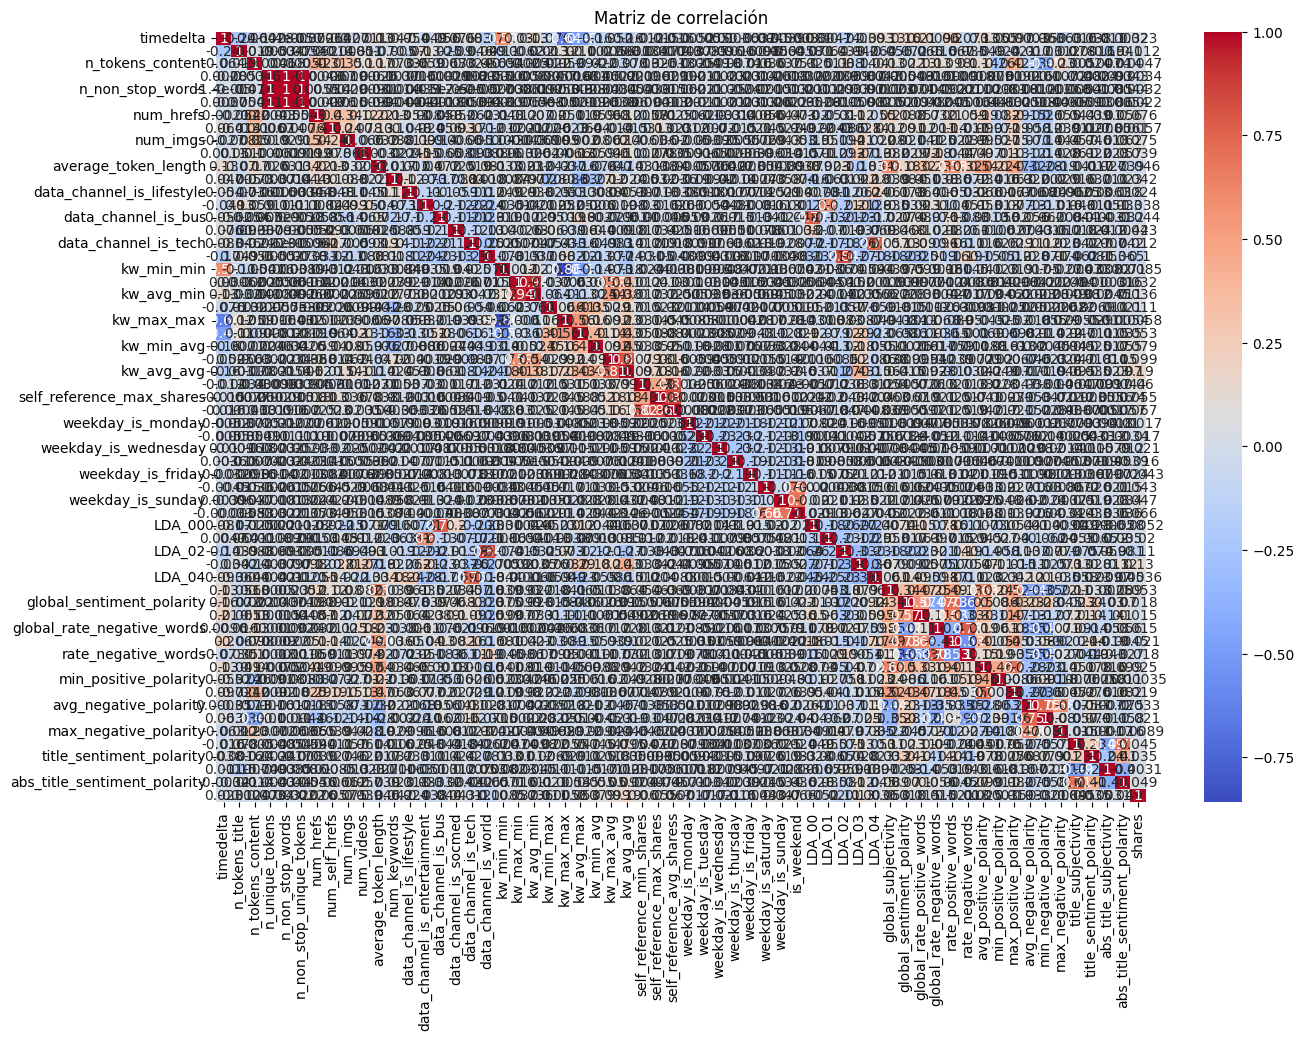

Pares de variables con correlaciones altas:
n_non_stop_unique_tokens      n_unique_tokens                 0.999854
n_unique_tokens               n_non_stop_unique_tokens        0.999854
                              n_non_stop_words                0.999577
n_non_stop_words              n_unique_tokens                 0.999577
n_non_stop_unique_tokens      n_non_stop_words                0.999539
n_non_stop_words              n_non_stop_unique_tokens        0.999539
kw_avg_min                    kw_max_min                      0.938494
kw_max_min                    kw_avg_min                      0.938494
kw_max_max                    kw_min_min                      0.857243
kw_min_min                    kw_max_max                      0.857243
self_reference_max_shares     self_reference_avg_sharess      0.856130
self_reference_avg_sharess    self_reference_max_shares       0.856130
LDA_02                        data_channel_is_world           0.836989
data_channel_is_world         LDA

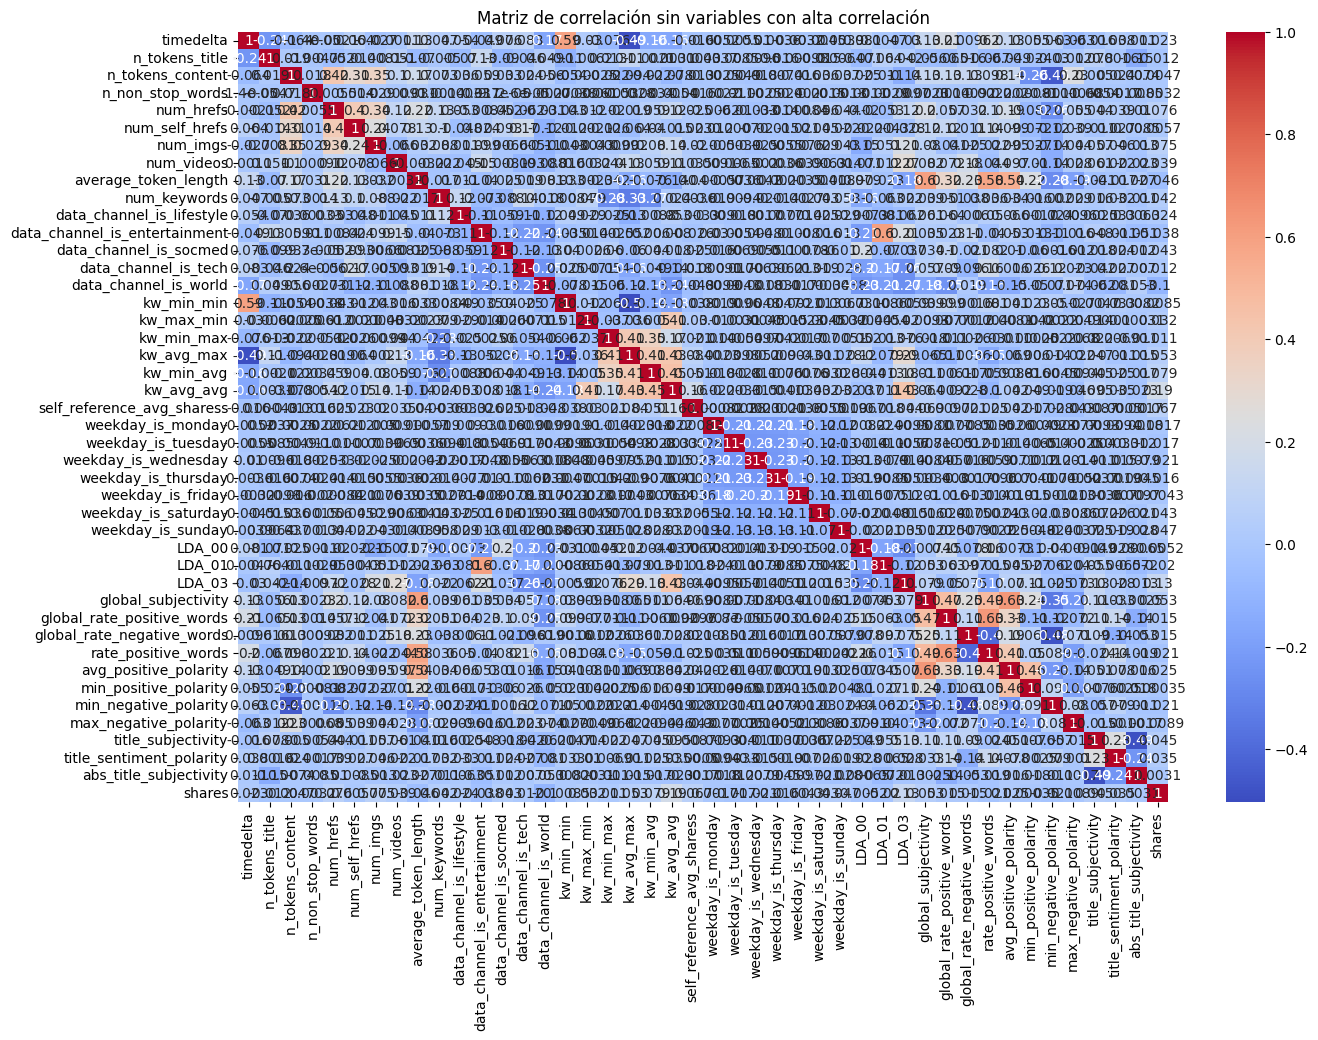

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar la distribución de la variable objetivo "shares" con outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_mashable["shares"], bins=50, kde=True)
plt.title("Distribución de la variable 'shares' con outliers")
plt.xlabel("Shares")
plt.ylabel("Frecuencia")
plt.show()

# Eliminar outliers (consideraremos valores mayores al percentil 99 como outliers)
percentile_99 = df_mashable["shares"].quantile(0.99)
df_mashable_no_outliers = df_mashable[df_mashable["shares"] <= percentile_99]

# Mostrar la distribución de la variable objetivo "shares" sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(df_mashable_no_outliers["shares"], bins=50, kde=True)
plt.title("Distribución de la variable 'shares' sin outliers")
plt.xlabel("Shares")
plt.ylabel("Frecuencia")
plt.show()

# Calcular y mostrar las correlaciones entre las variables numéricas
correlation_matrix = df_mashable_no_outliers.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

# Lista de variables con correlaciones mayores a 0.7 en términos absolutos
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.7) & (high_corr_pairs < 1)]
print("Pares de variables con correlaciones altas:")
print(high_corr_pairs)

# Eliminar una variable de cada par con correlación alta
variables_to_drop = set()
for var1, var2 in high_corr_pairs.index:
    if var1 not in variables_to_drop and var2 not in variables_to_drop:
        variables_to_drop.add(var1)

df_mashable_no_high_corr = df_mashable_no_outliers.drop(columns=list(variables_to_drop))

# Mostrar la matriz de correlación después de eliminar variables con alta correlación
correlation_matrix_no_high_corr = df_mashable_no_high_corr.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_no_high_corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación sin variables con alta correlación")
plt.show()

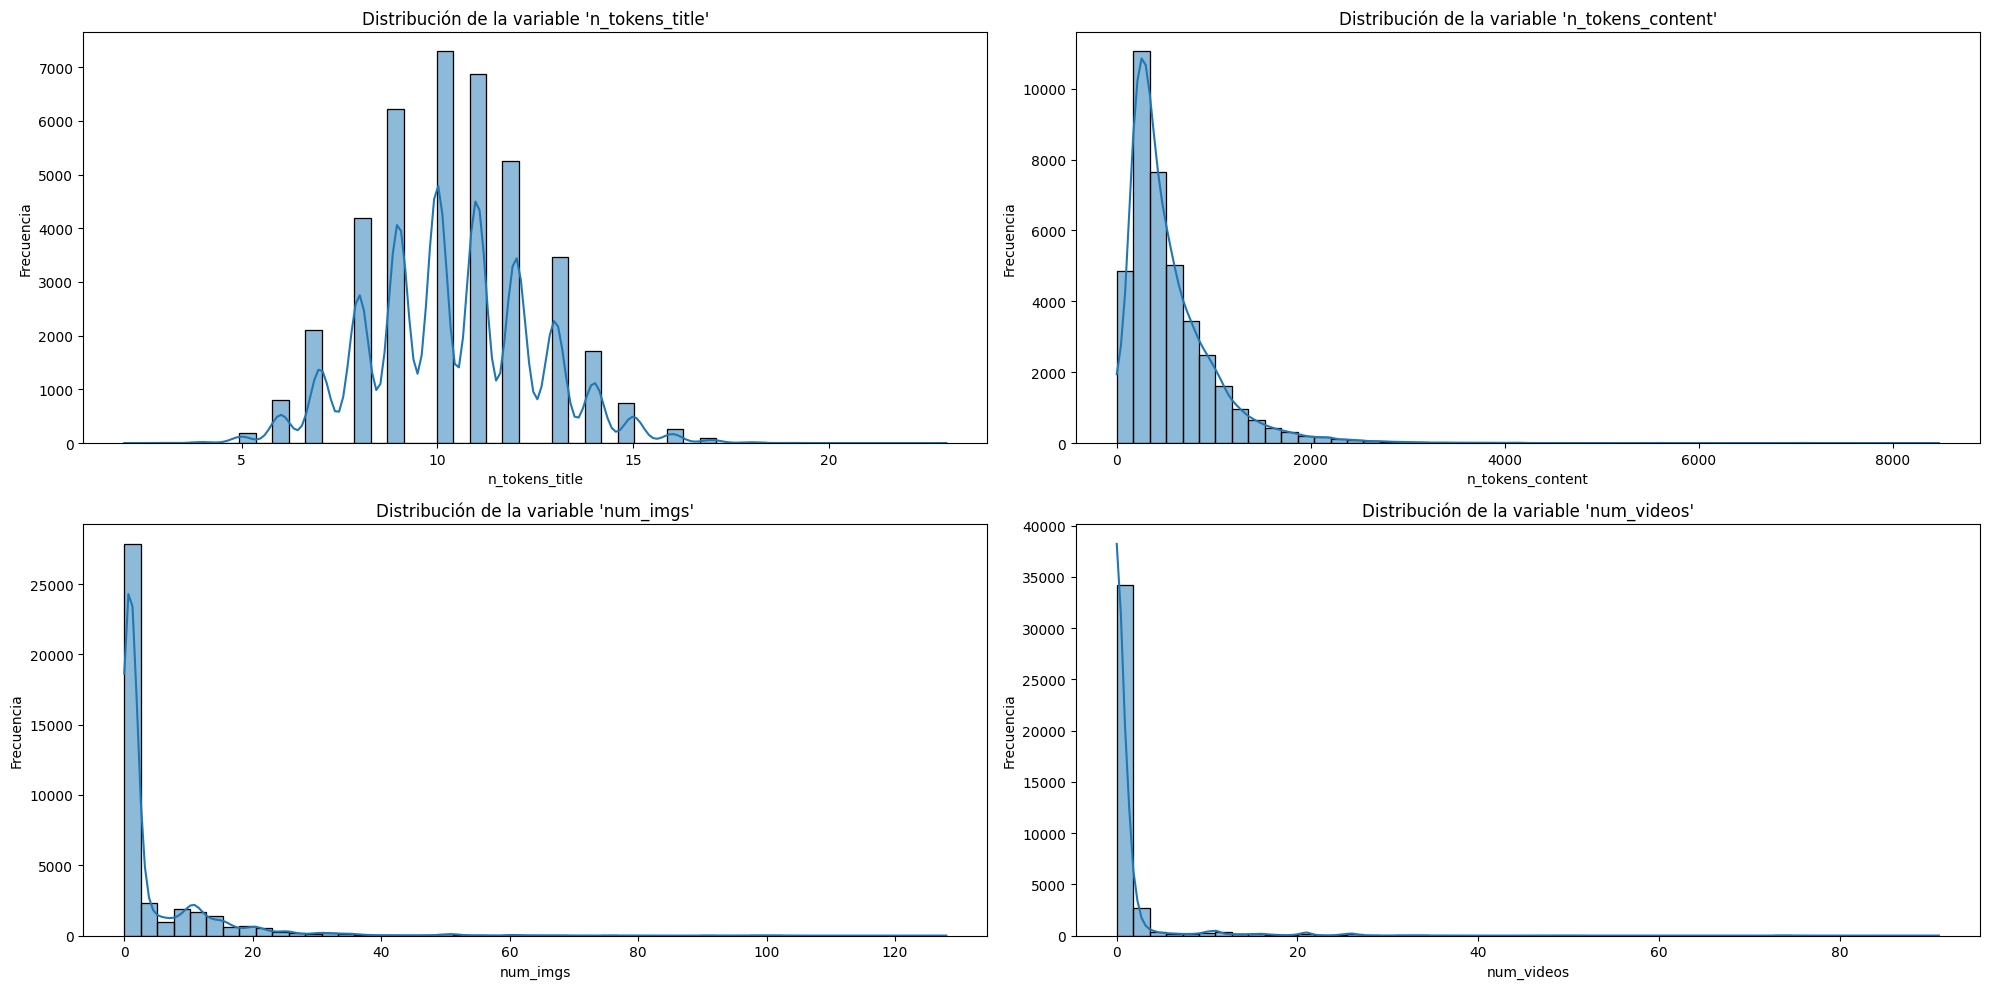

In [10]:
# Seleccionar cuatro variables numéricas para analizar su distribución
variables_to_analyze = ["n_tokens_title", "n_tokens_content", "num_imgs", "num_videos"]

# Mostrar histogramas para cada una de las variables seleccionadas
plt.figure(figsize=(20, 10))
for i, variable in enumerate(variables_to_analyze, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_mashable_no_high_corr[variable], bins=50, kde=True)
    plt.title(f"Distribución de la variable '{variable}'")
    plt.xlabel(variable)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler

# Seleccionar las variables numéricas
numeric_vars = df_mashable_no_high_corr.select_dtypes(include=[np.number]).columns

# Normalizar las variables numéricas
scaler = StandardScaler()
df_mashable_no_high_corr[numeric_vars] = scaler.fit_transform(
    df_mashable_no_high_corr[numeric_vars]
)

# Dividir los datos en entrenamiento y test (33%)
X = df_mashable_no_high_corr.drop(columns=["shares"])
y = df_mashable_no_high_corr["shares"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

print("Datos normalizados y divididos en conjuntos de entrenamiento y prueba.")

Datos normalizados y divididos en conjuntos de entrenamiento y prueba.


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Definir el modelo de Random Forest y los parámetros para GridSearch
rf = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": np.linspace(100, 300, 10, dtype=int),
    "max_depth": np.linspace(2, 15, 10, dtype=int),
    "max_features": ["sqrt", "log2"],
}

# Realizar la búsqueda de grilla con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y evaluar en el conjunto de prueba
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mejores Hiperparámetros: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
fc_model = Sequential()
fc_model.add(Dense(units=512, activation="relu", input_shape=(X_train.shape[1],)))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(units=256, activation="relu"))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(units=128, activation="relu"))
fc_model.add(Dropout(0.5))
fc_model.add(Dense(units=1, activation="linear"))

# Compilar el modelo
fc_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["mse", "mae"],
)

# Entrenar el modelo
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
fc_history = fc_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
)

# Evaluar el modelo
fc_loss, fc_mse, fc_mae = fc_model.evaluate(X_test, y_test)
print(f"Fully Connected Neural Network - MSE: {fc_mse}, MAE: {fc_mae}")

Epoch 1/20
370/370 [==============================] - 5s 10ms/step - loss: 1.0039 - mse: 1.0039 - mae: 0.5842 - val_loss: 0.9743 - val_mse: 0.9743 - val_mae: 0.5526
Epoch 2/20
370/370 [==============================] - 4s 10ms/step - loss: 0.9577 - mse: 0.9577 - mae: 0.5613 - val_loss: 0.9724 - val_mse: 0.9724 - val_mae: 0.5786
Epoch 3/20
370/370 [==============================] - 3s 9ms/step - loss: 0.9412 - mse: 0.9412 - mae: 0.5539 - val_loss: 0.9689 - val_mse: 0.9689 - val_mae: 0.5513
Epoch 4/20
370/370 [==============================] - 4s 10ms/step - loss: 0.9336 - mse: 0.9336 - mae: 0.5483 - val_loss: 0.9623 - val_mse: 0.9623 - val_mae: 0.5492
Epoch 5/20
370/370 [==============================] - 4s 10ms/step - loss: 0.9285 - mse: 0.9285 - mae: 0.5497 - val_loss: 0.9507 - val_mse: 0.9507 - val_mae: 0.5580
Epoch 6/20
370/370 [==============================] - 4s 10ms/step - loss: 0.9237 - mse: 0.9237 - mae: 0.5497 - val_loss: 0.9517 - val_mse: 0.9517 - val_mae: 0.5412
Epoch 7/20


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Definir el modelo XGBoost y los parámetros para GridSearch
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid_xgb = {
    "n_estimators": [100, 120, 150, 200, 300],
    "learning_rate": [0.008, 0.07, 0.009, 0.01, 0.02],
    "subsample": np.linspace(0.05, 1, 5),
    "scale_pos_weight": np.linspace(0.8, 0.9, 2),
}

# Realizar la búsqueda de grilla con validación cruzada de 5 folds
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="neg_mean_squared_error",
)
grid_search_xgb.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Calcular las métricas
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R2 Score: {r2_xgb}")

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Obtener la importancia de las características
importance = best_xgb_model.feature_importances_

# Crear un DataFrame para la importancia de características
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importance})

# Ordenar por importancia
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Graficar la importancia de características
plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for XGBoost Model")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import util_bagging as ubagging
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Definir los estimadores heterogéneos
estimators = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
]

# Entrenar el modelo de Bagging
T = 10  # Número de muestras bootstrap
trained_models, yhat_test, yhat_out, idx_oob = ubagging.bagging_het(
    X_train, y_train, T, estimators, X_test
)

# Evaluar el modelo de Bagging
mse_bagging = mean_squared_error(y_test, yhat_out)
r2_bagging = r2_score(y_test, yhat_out)

print(f"Bagging - Mean Squared Error: {mse_bagging}")
print(f"Bagging - R2 Score: {r2_bagging}")

In [ ]:
# Crear un DataFrame para comparar los resultados de los modelos
results_df = pd.DataFrame(
    {
        "Model": ["Random Forest", "Neural Network", "XGBoost", "Bagging"],
        "Mean Squared Error": [mse_rf, mse_nn, mse_xgb, mse_bagging],
        "R2 Score": [r2_rf, r2_nn, r2_xgb, r2_bagging],
    }
)

print(results_df)

In [ ]:
# Crear un DataFrame para comparar los resultados de los modelos
results_df = pd.DataFrame(
    {
        "Model": ["Random Forest", "Neural Network", "XGBoost", "Bagging"],
        "Mean Squared Error": [mse_rf, mse_nn, mse_xgb, mse_bagging],
        "R2 Score": [r2_rf, r2_nn, r2_xgb, r2_bagging],
    }
)

print(results_df)